<a href="https://colab.research.google.com/github/greenty5/ict2022_fluidDynamics/blob/main/Sample_OWM_CFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fluid Dynamics with Python (for UTM Internship Program 2022)
=====
***

This session, we will learn how to obtain weather and map data by using [OWM](https://pyowm.readthedocs.io/en/latest/v3/code-recipes.html) and [smopy](https://notebook.community/tomkooij/smopy/examples/example1). 

### How to use OWM library

In [ ]:
# we need pyowm and smopy libraries. In Google Colaboratory, additional libraries are called as shown follow;
!pip install pyowm smopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.0 MB/s 


Load libraries ...

In [ ]:
import smopy
import pyowm
import cv2
import numpy as np
import matplotlib.pyplot as plt

Input your OWM API here;

In [ ]:
owm = pyowm.OWM('please enter your OWM API here') # pls input your OWM API 

Let us check owm data utilization

In [ ]:
mgr = owm.weather_manager()

# lon = 60.170405; lat = 24.941538 # Helsinki
lat = 1.559; lon = 103.638 # UTM campus

observation = (mgr.weather_at_coords(lat,lon))
#observation = mgr.weather_at_place('Tokyo,JP')
wind = observation.weather
#print(wind['deg'])
print("wind angle is ...", wind.wind()['deg'], "[deg]")
print("wind speed is ... {:.3f} [m/s]".format(wind.wind()['speed']))

wind angle is ... 0 [deg]
wind speed is ... 1.030 [m/s]


In [ ]:
#observation = mgr.weather_at_place('Tokyo,JP')
wind = observation.weather
#print(wind.detailed_status)
wind_dict_in_meters_per_sec = observation.weather.wind()   # Default unit: 'meters_sec'
wind_dict_in_meters_per_sec['speed']
wind_dict_in_meters_per_sec['deg']
#wind_dict_in_meters_per_sec['gust']
#wind_dict_in_miles_per_h = mgr.weather_at_place('Tokyo,JP').wind(unit='miles_hour')
#wind_dict_in_knots = mgr.weather_at_place('Tokyo,JP').wind(unit='knots')
#wind_dict_in_beaufort = mgr.weather_at_place('Tokyo,JP').wind(unit='beaufort')  # Beaufort is 0-12 scale

0

In [ ]:
# mgr = owm.weather_manager()
'''
weather = mgr.weather_at_place('Tokyo,JP').weather
temp_dict_kelvin = weather.temperature()   # a dict in Kelvin units (default when no temperature units provided)
temp_dict_kelvin['temp_min']
temp_dict_kelvin['temp_max']
temp_dict_fahrenheit = weather.temperature('fahrenheit')  # a dict in Fahrenheit units
temp_dict_celsius = weather.temperature('celsius')  # guess?

print("highest temperature is \t {} [K]".format(temp_dict_kelvin['temp_max']))
'''

'\nweather = mgr.weather_at_place(\'Tokyo,JP\').weather\ntemp_dict_kelvin = weather.temperature()   # a dict in Kelvin units (default when no temperature units provided)\ntemp_dict_kelvin[\'temp_min\']\ntemp_dict_kelvin[\'temp_max\']\ntemp_dict_fahrenheit = weather.temperature(\'fahrenheit\')  # a dict in Fahrenheit units\ntemp_dict_celsius = weather.temperature(\'celsius\')  # guess?\n\nprint("highest temperature is \t {} [K]".format(temp_dict_kelvin[\'temp_max\']))\n'

---

In [ ]:
'''
reg = owm.city_id_registry()
list_of_locations = reg.locations_for('Tokyo', country='JP', matching='exact')
tokyo = list_of_locations[0]
lat = tokyo.lat   # 35.689499
lon = tokyo.lon   # 139.691711

print(lat)
'''

"\nreg = owm.city_id_registry()\nlist_of_locations = reg.locations_for('Tokyo', country='JP', matching='exact')\ntokyo = list_of_locations[0]\nlat = tokyo.lat   # 35.689499\nlon = tokyo.lon   # 139.691711\n\nprint(lat)\n"

### How to use smopy library

Now, let us learn how to handle map data by using smopy and cv2.
Please note that the order of variables of smopy.Map function is reverse oder, that is, "smopy.Map(latitude, longitude)". 

(256, 256, 3)

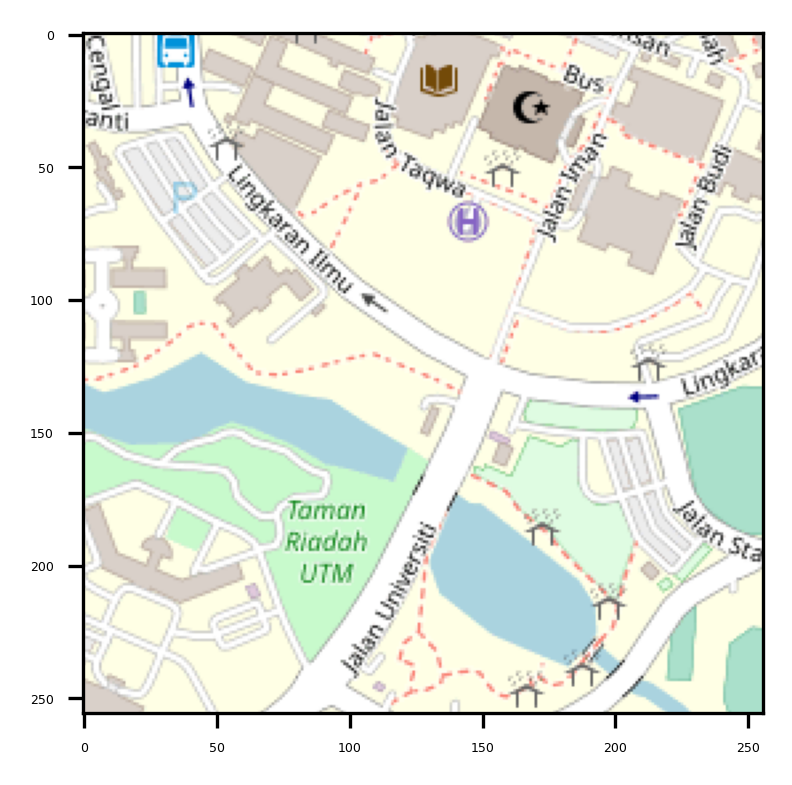

In [ ]:
#map = smopy.Map((lon, lat, lon+0.1, lat+0.1), z=16)
map = smopy.Map(lat, lon, z=16)
#map = smopy.Map((42., -1., 55., 3.), z=4)
mapImg = map.to_numpy()

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=3)
ax.imshow(mapImg)
mapImg.shape

resize the image ...

(100, 100, 3)

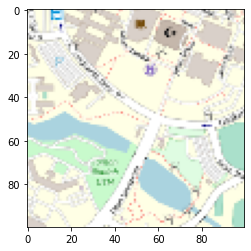

In [ ]:
lowImg = cv2.resize(mapImg, (100,100))
plt.imshow(lowImg)
lowImg.shape

convert color pattern from BGR to [HSV](http://color.lukas-stratmann.com/color-systems/hsv.html) and mask the map in order to obtain building data.

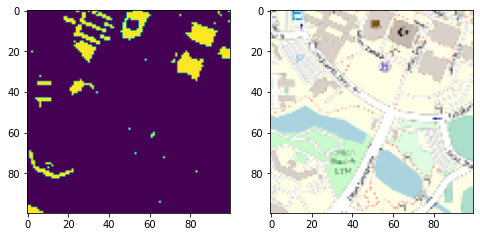

In [ ]:
lower = np.array([100,19,100]) # HSV (hue/lightness, saturation/chroma, value/brightness)
upper = np.array([150,20,250])
#hsv = cv2.cvtColor(mapImg, cv2.COLOR_BGR2HSV)
hsv = cv2.cvtColor(lowImg, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower, upper)
#maskedMapImg = cv2.bitwise_and(mapImg, mapImg, mask)
maskedMapImg = cv2.bitwise_and(lowImg, lowImg, mask)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(mask) # building data
ax2.imshow(maskedMapImg)


In [ ]:
print(maskedMapImg.shape)
print(mask.shape)

(100, 100, 3)
(100, 100)


(100, 100, 3)

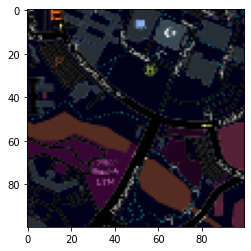

In [ ]:
negaMap = 255 - maskedMapImg # calculating turnover value of mskedMapImg (hsv data).
plt.imshow(negaMap)
negaMap.shape

In [ ]:
# for check the arrays

#maskedMapImg
#negaMap

---

In [ ]:
# Function for fluid flow calculation
#
# Some processings (obstacles,export wind UV images) are modified by Jun Hirabayashi.
# 

#import numpy
import math
import json
import datetime
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def loadVelocityMask(u,v,mask): #, mask_u, mask_v, u, v):
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] == 255:
                u[y, x] = 0.0
                v[y, x] = 0.0
    return True

def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] ##dp/dy = 0 at x = end
        p[0, :]  = p[1, :]  ##dp/dy = 0 at y = 0
        p[:, 0]  = p[:, 1]  ##dp/dx = 0 at x = 0
        p[-1, :] = p[-2, :] ##dp/dx = 0 at y = end
    return p

def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b

def cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, mask, deg, speed):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    for n in range(nt):
        loadVelocityMask(u,v,mask)
        un = u.copy()
        vn = v.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        loadVelocityMask(u,v,mask)

        wind_u = -math.sin(deg/180.0*math.pi)*speed
        wind_v = -math.cos(deg/180.0*math.pi)*speed
        # y, x
        u[0, :] = wind_u
        u[:, 0] = wind_u
        u[:, -1] = wind_u
        u[-1, :] = wind_u
        
        v[0, :] = wind_v
        v[-1, :]= wind_v
        v[:, 0] = wind_v
        v[:, -1] = wind_v
    return u, v, p

def doSimulation(nx, ny, wind, mask, isWithUVMap):
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    X, Y = np.meshgrid(x, y)
    rho = 1
    nu = .1
    dt = .00001
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))
    nt = 20
    u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
                           mask, wind['deg'], wind['speed'])
#    try:
#        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
#                           mask, wind['deg'], wind['speed'])
#    except:
#        u, v, p = cavity_flow_mask(nt, nx, ny, u, v, dt, dx, dy, p, rho, nu, 
#                           mask, 0, wind['speed'])
        
    velocity = np.zeros((ny, nx))
    velocity[1:-1,1:-1] = np.sqrt(pow(v[1:-1,1:-1],2)+pow(u[1:-1,1:-1],2))

    # calculating velocity contour map
    umax = np.amax(u)
    umin = np.amin(u)
    vmax = np.amax(v)
    vmin = np.amin(v)
    uvImage = np.zeros((ny, nx, 4), np.uint8)
    for y in range(ny):
        for x in range(nx):
            uvImage[x,y] = (
                0,
                math.floor(255 * (v[x,y] - vmin) / (vmax - vmin)),
                math.floor(255 * (u[x,y] - umin) / (umax - umin)),
                255)
    uvmeta = {'source': 'http://www.hirax.net', 
        'date': str(datetime.datetime.now()),
        'width': nx,
        'height': ny,
        'uMin': umin,
        'uMax': umax,
        'vMin': vmin,
        'vMax': vmax
       }
    if('withUVMap'==isWithUVMap):
        return u, v, velocity, uvmeta, uvImage
    if('withOutUVMap'==isWithUVMap):
        return u, v, velocity
    else:
        return u, v, velocity        

In [ ]:
mask.shape[0]
nx = mask.shape[0]
ny = mask.shape[1]

In [ ]:
nit = 100
#u, v, velocity = doSimulation(mask.shape[0], mask.shape[1], wind.wind(), mask, 'withOutUVMap')
u, v, velocity = doSimulation(nx, ny, wind.wind(), mask, 'withOutUVMap')

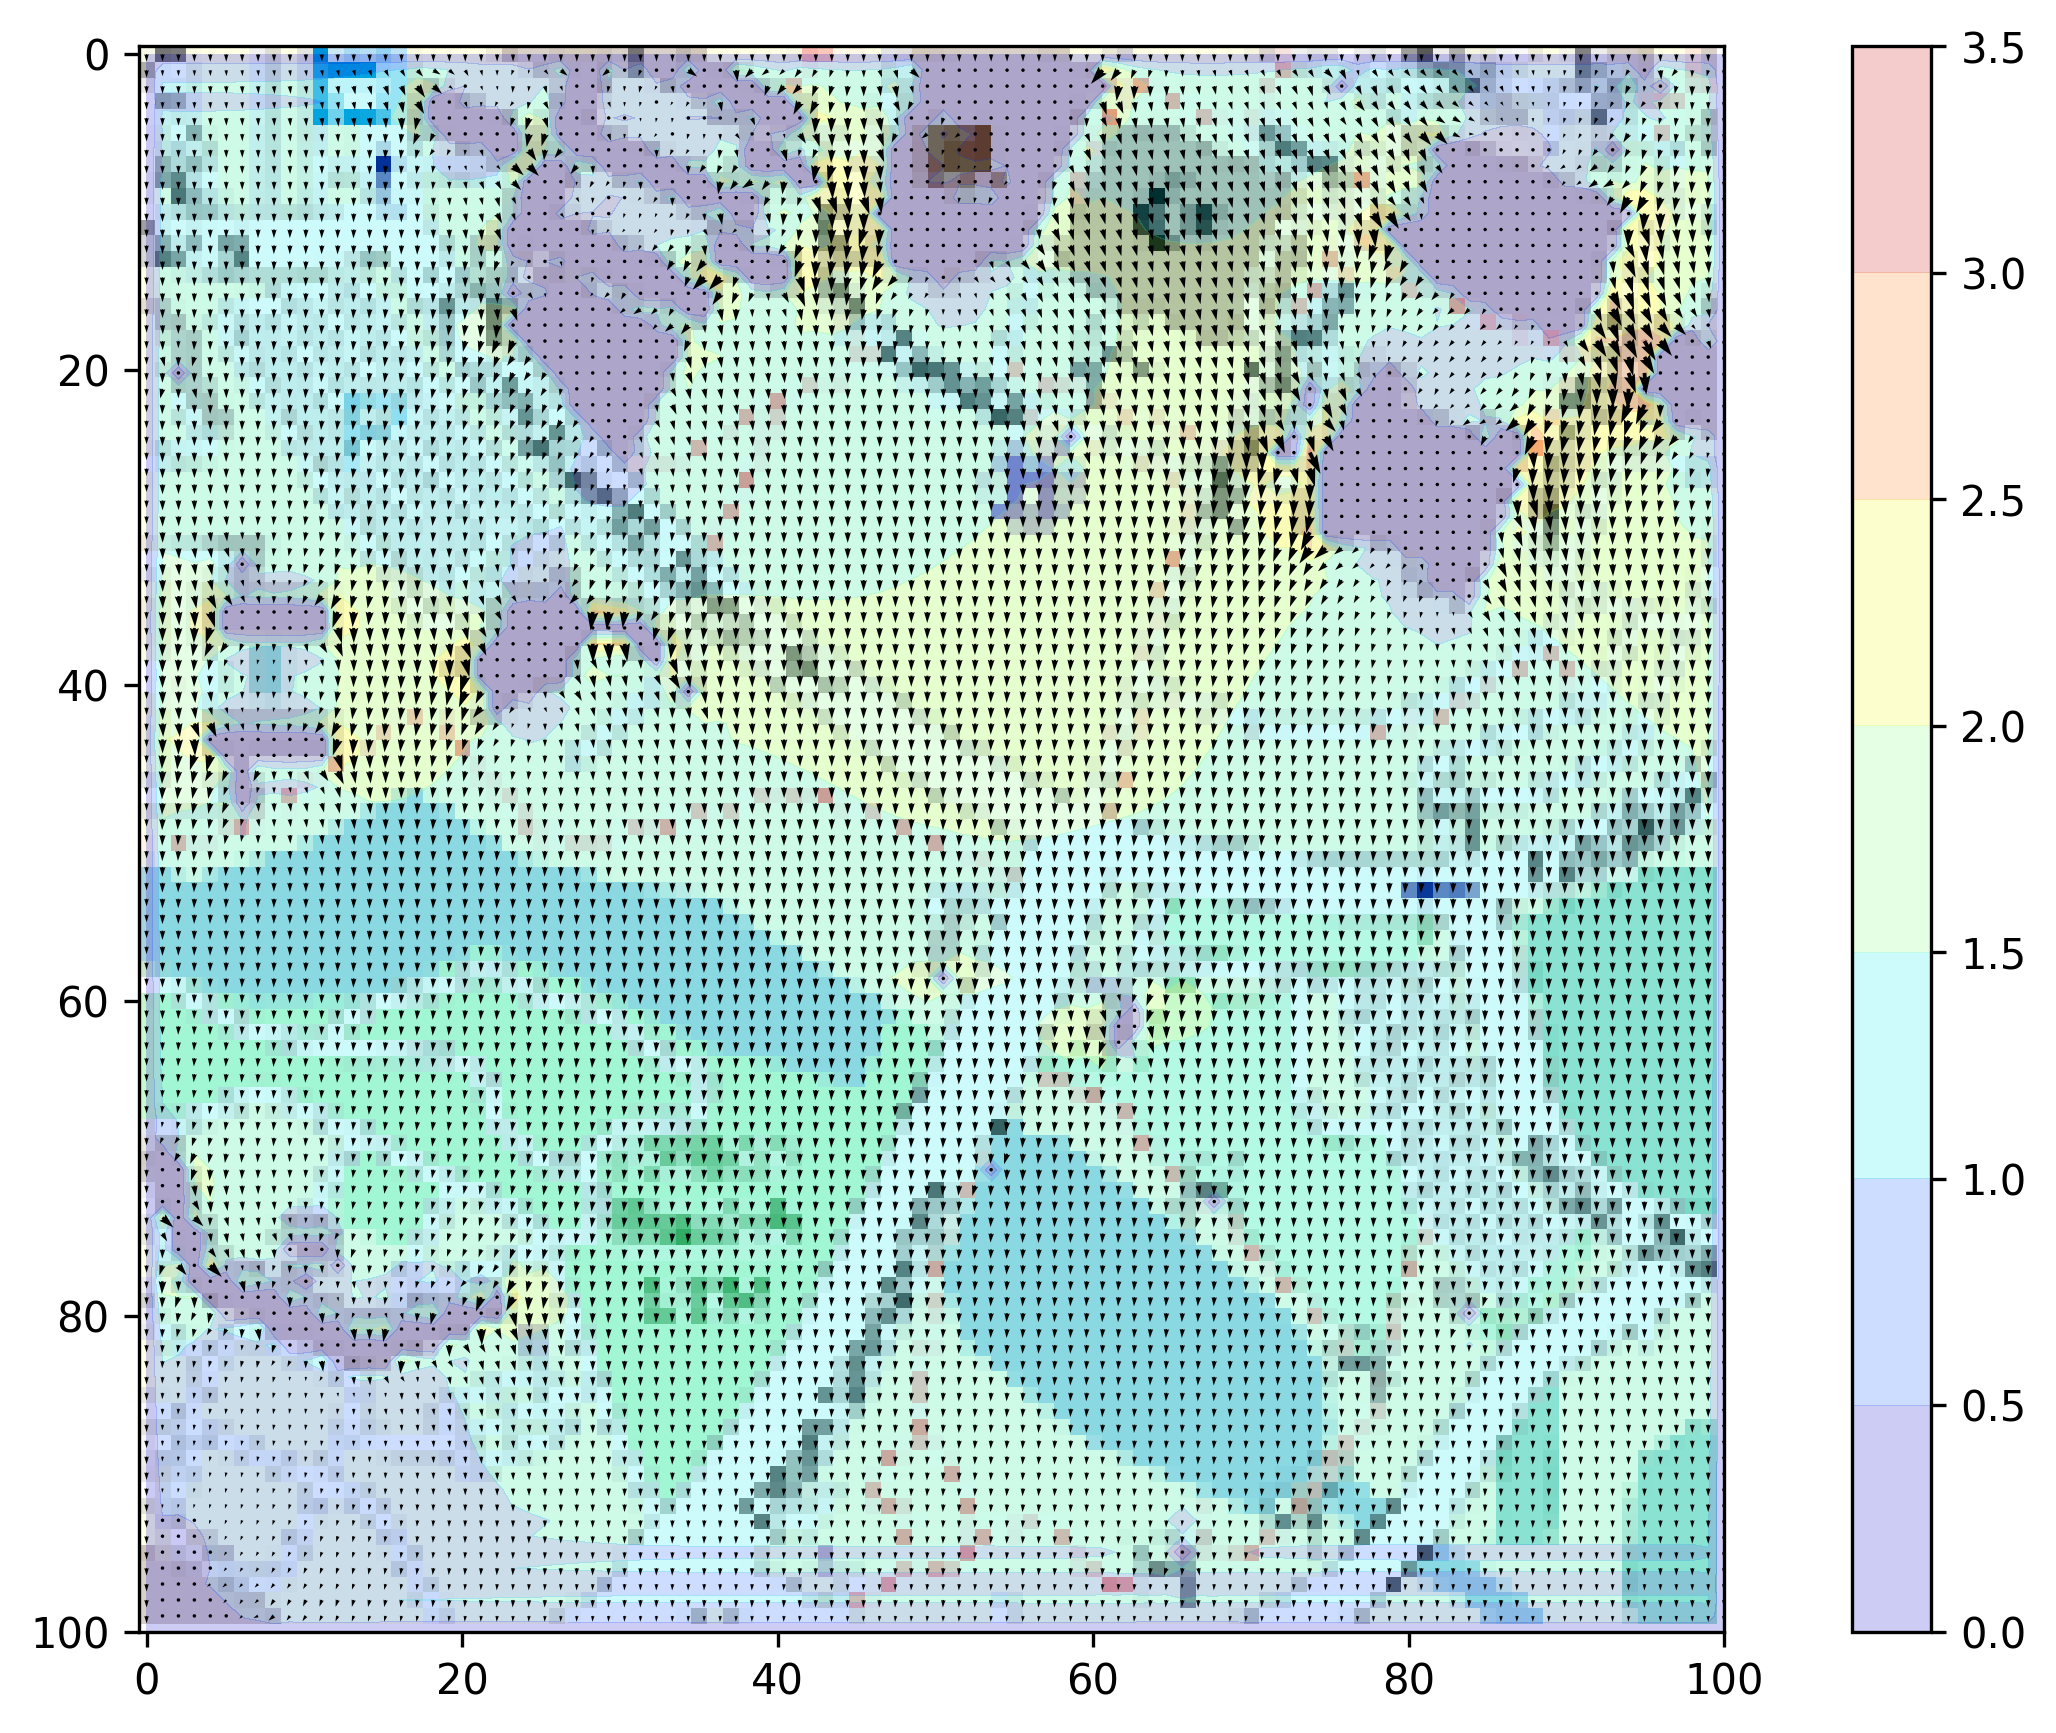

In [ ]:
fig = plt.figure(figsize=(11,7), dpi=300)
ax = fig.add_subplot(111)

ax.imshow(lowImg)
plotX, plotY = np.meshgrid(np.linspace(0,nx, nx), np.linspace(0,ny,ny))
plt.contourf(plotX, plotY, velocity, alpha=0.2, cmap=cm.jet)
plt.colorbar()
plt.quiver(plotX, plotY, u, v)
plt.show()

----

Good job, everyone 😃